In [2]:
!pip install pandas matplotlib seaborn aesara pymc
!pip install scipy==1.10.1
!pip install numpy==1.23.0

!export MKL_THREADING_LAYER=GNU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 36.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all

In [1]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import aesara # Import aesara first
import aesara.tensor as at # Then import aesara.tensor
import aesara.compile # Finally, import aesara.compile

In [18]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Load COVID-19 data from Johns Hopkins University
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
print(df)
# Aggregate by country and drop coordinates
df = df.groupby('Country/Region').sum().drop(columns=['Lat', 'Long']).T

# Drop non-date rows like 'Province/State'
df = df.loc[df.index.str.match(r'\d{1,2}/\d{1,2}/\d{2}')]  # Keep only rows matching date format (e.g., "1/22/20")
df.index = pd.to_datetime(df.index, format='%m/%d/%y')

# Compute daily new cases and handle missing values
df = df.diff().fillna(0).reset_index()

# Choose countries for analysis (top 5 by cases for simplicity)
countries = ['US', 'India', 'Brazil', 'Russia', 'United Kingdom']
df = df[['index'] + countries]  # Include the date column for time series

# Log-transform to stabilize variance
df[countries] = np.log1p(df[countries])

print(df)

    Province/State        Country/Region        Lat        Long  1/22/20  \
0              NaN           Afghanistan  33.939110   67.709953        0   
1              NaN               Albania  41.153300   20.168300        0   
2              NaN               Algeria  28.033900    1.659600        0   
3              NaN               Andorra  42.506300    1.521800        0   
4              NaN                Angola -11.202700   17.873900        0   
..             ...                   ...        ...         ...      ...   
284            NaN    West Bank and Gaza  31.952200   35.233200        0   
285            NaN  Winter Olympics 2022  39.904200  116.407400        0   
286            NaN                 Yemen  15.552727   48.516388        0   
287            NaN                Zambia -13.133897   27.849332        0   
288            NaN              Zimbabwe -19.015438   29.154857        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  \
0          0 

<ipython-input-18-72fa56151c97>:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.diff().fillna(0).reset_index()
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


<ipython-input-19-86e47bcf8c03>:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.diff().fillna(0).reset_index()
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


Loading existing trace file...


Output()

<ipython-input-19-86e47bcf8c03>:140: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  post_pred = pm.sample_posterior_predictive(trace)



Debug Information:
DataFrame shape: (1143, 2)
Observed data shape for US: (1143,)
Post predictive shape: (1, 100, 1143, 1)
Predictions numpy array shape: (1, 100, 1143, 1)


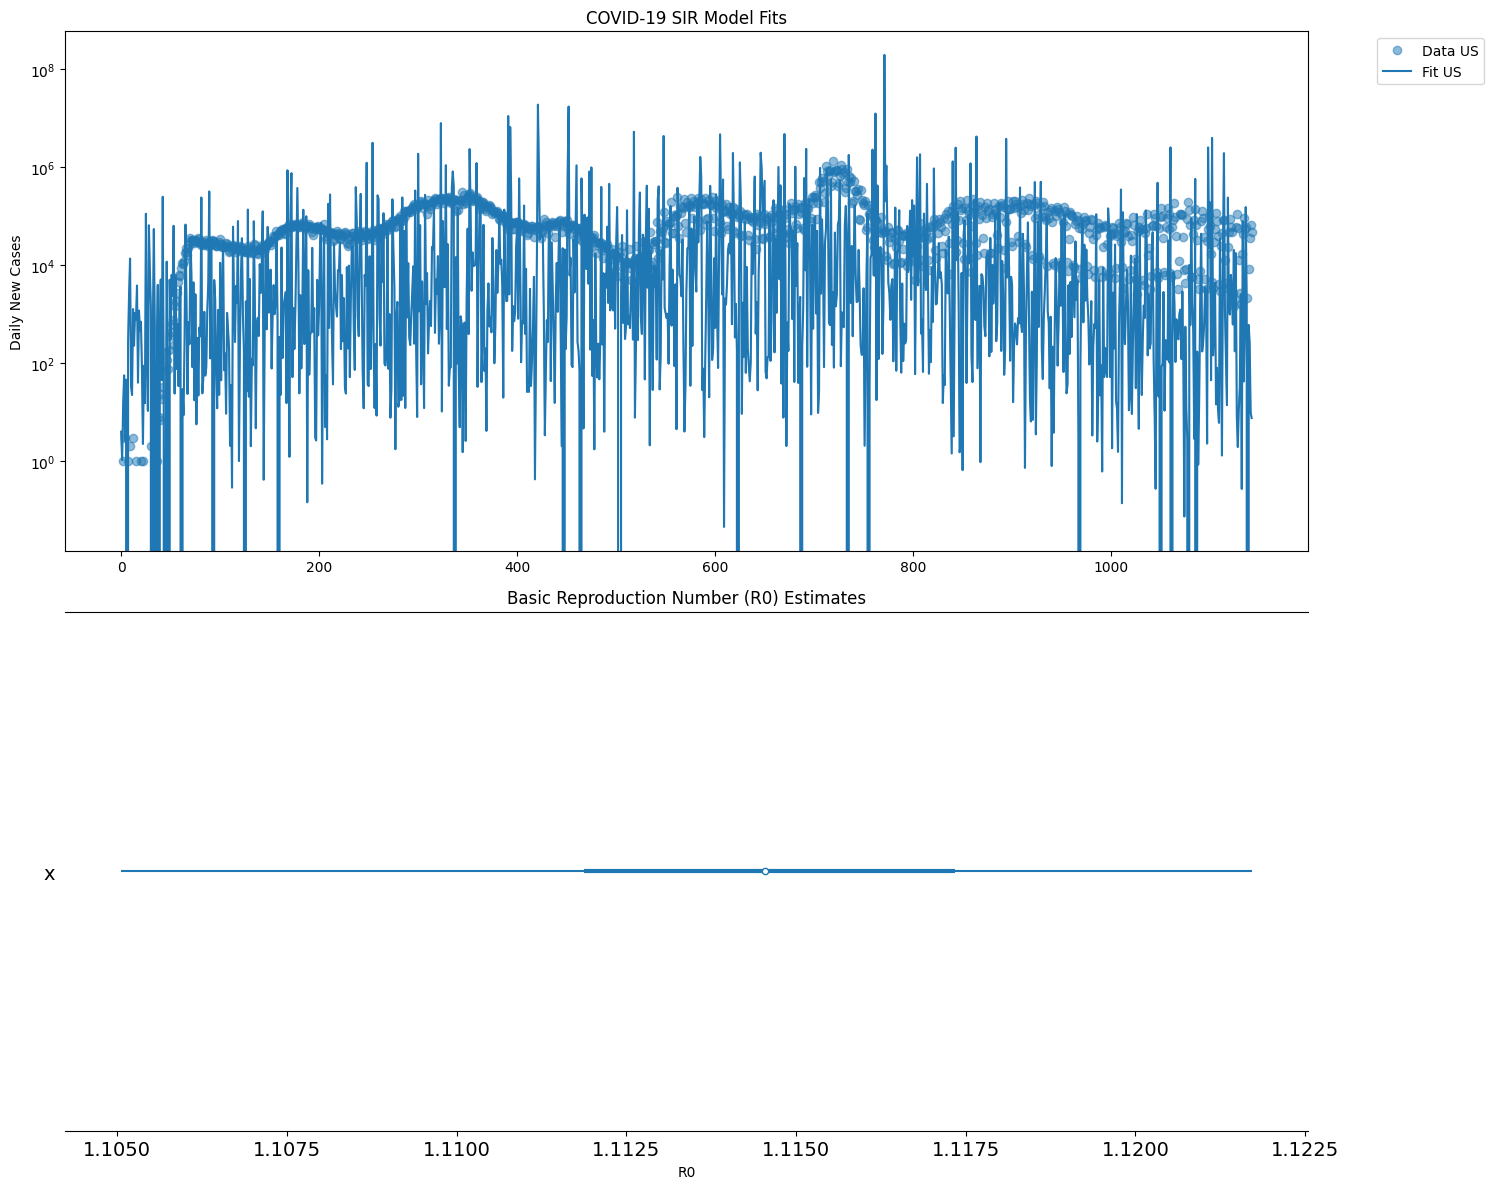

In [19]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Data loading and preprocessing
def load_covid_data():
    """Load and preprocess COVID-19 data"""
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    df = pd.read_csv(url)

    # Aggregate by country and drop coordinates
    df = df.groupby('Country/Region').sum().drop(columns=['Lat', 'Long']).T

    # Drop non-date rows and convert to datetime
    df = df.loc[df.index.str.match(r'\d{1,2}/\d{1,2}/\d{2}')]
    df.index = pd.to_datetime(df.index, format='%m/%d/%y')

    # Compute daily new cases and handle missing values
    df = df.diff().fillna(0).reset_index()

    # Choose top 5 countries
    # countries = ['US', 'India', 'Brazil', 'Russia', 'United Kingdom']
    countries = ['US']
    df = df[['index'] + countries]

    # Log-transform to stabilize variance
    df[countries] = np.log1p(df[countries])

    return df, countries

def sir_ode(y, t, p):
    """
    SIR model dynamics
    """
    S, I, R = y[0],y[1],y[2]
    beta, gamma = p[0],p[1]

    N = S + I + R
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I

    return [dS, dI, dR]

def create_covid_sir_model(df, countries):
    """
    Create SIR model for COVID-19 data
    """
    n_countries = len(countries)
    t = np.arange(len(df))

    with pm.Model() as model:
        # Parameters with informative priors based on COVID-19 literature
        beta = pm.Lognormal('beta', mu=np.log(0.3), sigma=0.5, shape=n_countries)
        gamma = pm.Deterministic('gamma', pm.math.ones(n_countries) * 1/14)  # ~14 days recovery

        # Initial conditions (using actual population sizes would be better)
        N = 1e6
        I0 = pm.Lognormal('I0', mu=np.log(100), sigma=1, shape=n_countries)
        R0 = pm.Deterministic('R0', pm.math.zeros(n_countries))
        S0 = pm.Deterministic('S0', N - I0 - R0)

        # ODE solver
        ode = pm.ode.DifferentialEquation(
            func=sir_ode,
            times=t,
            n_states=3,
            n_theta=2,
            t0=0
        )

        # Solve for each country
        solutions = []
        for i in range(n_countries):
            y0 = [S0[i], I0[i], R0[i]]
            theta = [beta[i], gamma[i]]
            solution = ode(y0=y0, theta=theta)
            solutions.append(solution[:, 1])  # Only infected compartment

        solutions_stack = pm.math.stack(solutions, axis=1)

        # Log-transform model predictions to match data
        solutions_stack = pm.math.log(solutions_stack + 1)

        # Observation model
        sigma_obs = pm.HalfNormal('sigma_obs', sigma=1, shape=n_countries)

        # Observed data handling
        observed_data = df[countries].values
        mask = ~np.isnan(observed_data)

        # Create observed variable without missing values
        obs_data = observed_data.copy()
        obs_data[~mask] = 0  # Replace NaN with 0 for missing values

        # Likelihood with missing value handling
        obs = pm.Normal('obs',
                       mu=solutions_stack,
                       sigma=sigma_obs.reshape((1, -1)),
                       observed=obs_data)

        pm.Potential('missing_pot', pm.math.switch(
            mask.astype('int32'),
            0,
            -1e10  # Large negative value for missing data points
        ))

    return model, t

def fit_and_analyze_model(model, df, countries, t, draws=100, tune=50, chains=1):
    """
    Fit model and create analysis plots with proper handling of trace and predictions
    """
    trace_filename = Path("covid_sir_model_trace.nc")

    if trace_filename.exists():
        print("Loading existing trace file...")
        trace = az.from_netcdf(trace_filename)
    else:
        print("Trace file not found. Running sampling process...")
        with model:
            trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=1,
                target_accept=0.85,
                return_inferencedata=True
            )
            az.to_netcdf(trace, trace_filename)
            print(f"Trace saved to {trace_filename}")

    # Generate fresh posterior predictive samples
        print("Generating posterior predictive samples...")
    with model:
        post_pred = pm.sample_posterior_predictive(trace)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    for i, country in enumerate(countries):
        color = plt.cm.tab10(i / len(countries))

        # Plot observed data
        observed = np.exp(df[country]) - 1
        ax1.plot(range(len(df)), observed, 'o',
                color=color, alpha=0.5,
                label=f'Data {country}')

        # Get predictions and properly handle dimensions
        predictions = post_pred['posterior_predictive']['obs']

        # Convert xarray to numpy and handle dimensions
        pred_values = predictions.values  # Convert to numpy array

        # Calculate mean and std across the samples
        pred_mean = np.exp(np.mean(pred_values[:, i, :], axis=0)) - 1
        pred_std = np.std(pred_values[:, i, :], axis=0)

        # Reshape or select data for the current country
        pred_mean = pred_mean.squeeze()  # Remove unnecessary dimensions if present
        pred_std = pred_std.squeeze()  # Remove unnecessary dimensions if present

        # Plot mean prediction
        # The change is here: using range(len(pred_mean)) for x-axis to match the shape of pred_mean
        ax1.plot(range(len(pred_mean)), pred_mean, '-',
                color=color,
                label=f'Fit {country}')

        # Plot confidence intervals
        ax1.fill_between(
            range(len(df)),
            np.exp(np.mean(pred_values[:, i, :], axis=0).squeeze() - 2 * pred_std) - 1,
            np.exp(np.mean(pred_values[:, i, :], axis=0).squeeze() + 2 * pred_std) - 1,
            color=color,
            alpha=0.2
        )

    ax1.set_ylabel('Daily New Cases')
    ax1.set_title('COVID-19 SIR Model Fits')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_yscale('log')

    # Plot R0 estimates
    r0 = trace.posterior['beta'] / trace.posterior['gamma']
    az.plot_forest(r0, hdi_prob=0.95, ax=ax2)
    ax2.set_title('Basic Reproduction Number (R0) Estimates')
    ax2.set_xlabel('R0')

    plt.tight_layout()

    # Print shapes for debugging
    print("\nDebug Information:")
    print(f"DataFrame shape: {df.shape}")
    print(f"Observed data shape for {countries[0]}: {df[countries[0]].shape}")
    print(f"Post predictive shape: {predictions.shape}")
    print(f"Predictions numpy array shape: {pred_values.shape}")

    return trace, post_pred

# Main execution
df, countries = load_covid_data()

# Create model
model, t = create_covid_sir_model(df, countries)

# Fit model and generate plots
trace, predictions = fit_and_analyze_model(model, df, countries, t)

plt.show()



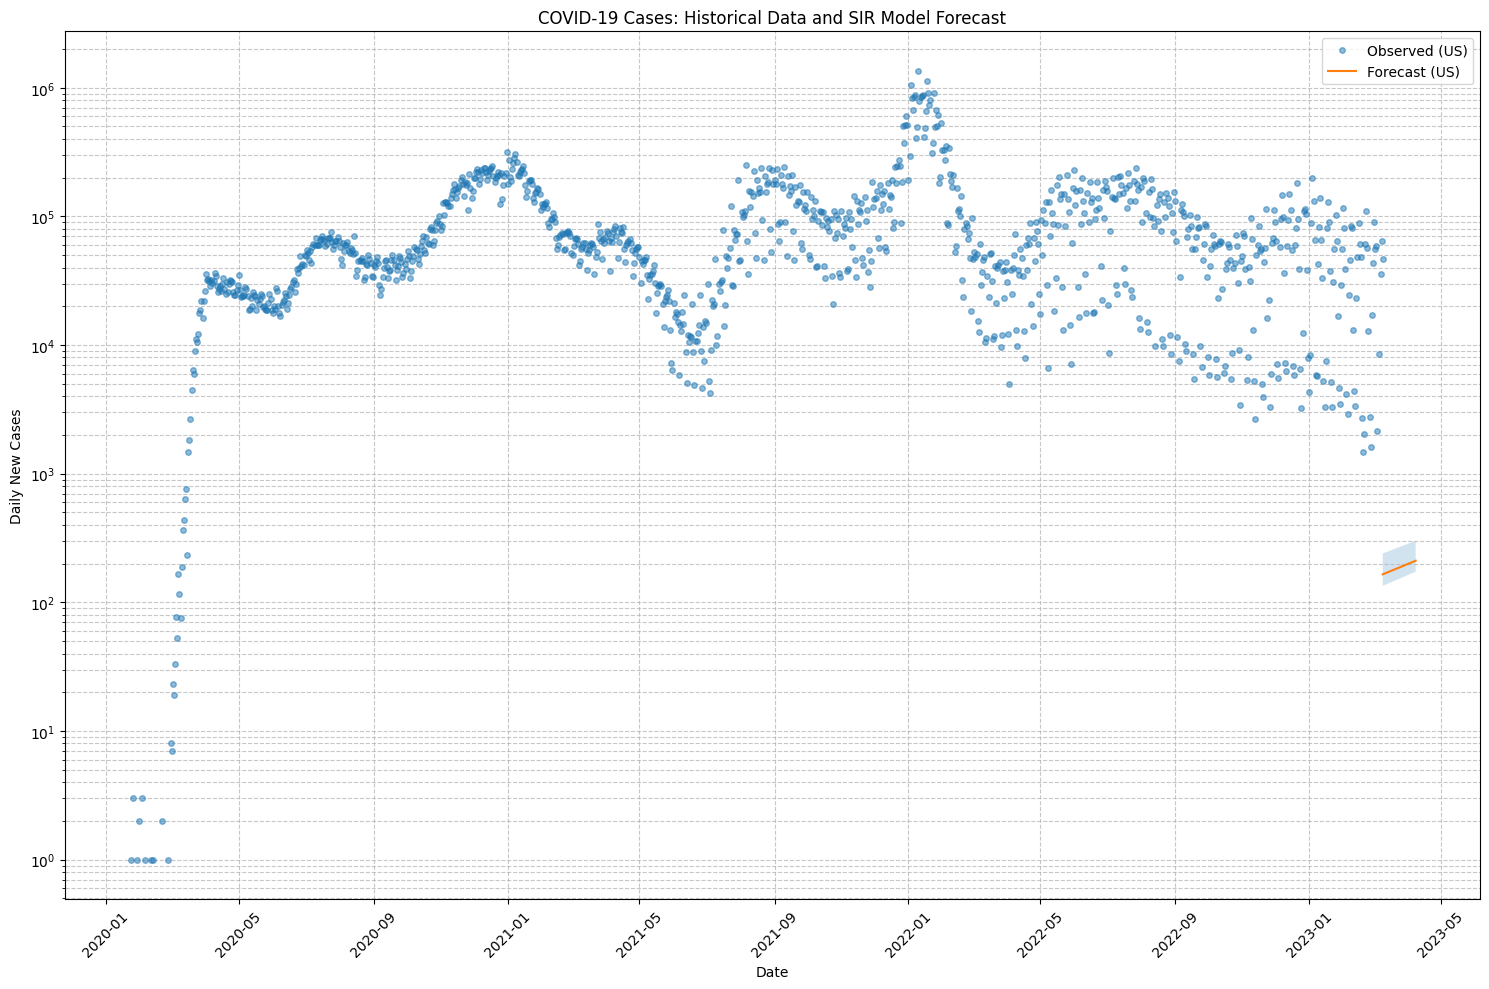

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def forecast_sir_model(trace, df, countries, forecast_days=30):
    """
    Generate forecasts using the trained SIR model

    Parameters:
    -----------
    trace : InferenceData
        PyMC trace containing the posterior samples
    df : DataFrame
        Original data containing dates and cases
    countries : list
        List of countries to forecast
    forecast_days : int
        Number of days to forecast (default: 30 days)
    """
    # Ensure datetime index
    df['index'] = pd.to_datetime(df['index'])
    last_date = df['index'].max()
    forecast_dates = pd.date_range(start=last_date, periods=forecast_days+1, freq='D')

    # Time points for integration (30 days forecast)
    t = np.arange(forecast_days+1)

    forecasts = {}
    for i, country in enumerate(countries):
        # Extract posterior samples
        beta_samples = trace.posterior['beta'].values.flatten()
        gamma_samples = trace.posterior['gamma'].values.flatten()
        I0_samples = trace.posterior['I0'].values.flatten()

        # Population size (from model)
        N = 1e6

        # Storage for predictions
        all_predictions = np.zeros((len(beta_samples), len(t)))

        # Generate predictions for each posterior sample
        for j in range(len(beta_samples)):
            # Initial conditions
            S0 = N - I0_samples[j]
            I0 = I0_samples[j]
            R0 = 0
            y0 = [S0, I0, R0]

            # Parameters for this sample
            params = [beta_samples[j], gamma_samples[j]]

            # Solve ODE system
            solution = odeint(
                lambda y, t, p: sir_ode(y, t, p),
                y0,
                t,
                args=(params,)
            )

            # Store infected cases
            all_predictions[j, :] = solution[:, 1]

        # Calculate statistics
        mean_prediction = np.mean(all_predictions, axis=0)
        lower_ci = np.percentile(all_predictions, 2.5, axis=0)
        upper_ci = np.percentile(all_predictions, 97.5, axis=0)

        # Store results
        forecasts[country] = {
            'dates': forecast_dates,
            'mean': mean_prediction,
            'lower': lower_ci,
            'upper': upper_ci
        }

    return forecasts

def plot_forecasts(forecasts, df, countries):
    """
    Plot the forecasts alongside historical data
    """
    plt.figure(figsize=(15, 10))

    for country in countries:
        # Plot historical data
        historical = np.exp(df[country].values) - 1  # Reverse log transform
        historical_dates = df['index']
        plt.plot(historical_dates, historical, 'o', label=f'Observed ({country})',
                alpha=0.5, markersize=4)

        # Plot forecast
        forecast = forecasts[country]
        plt.plot(forecast['dates'], forecast['mean'], '-',
                label=f'Forecast ({country})')
        plt.fill_between(forecast['dates'],
                        forecast['lower'], forecast['upper'],
                        alpha=0.2)

    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Daily New Cases')
    plt.title('COVID-19 Cases: Historical Data and SIR Model Forecast')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    return plt.gcf()

def sir_ode(y, t, params):
    """
    SIR model differential equations
    """
    S, I, R = y
    beta, gamma = params
    N = sum(y)

    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I

    return [dSdt, dIdt, dRdt]


# Generate forecasts (now for 30 days)
forecasts = forecast_sir_model(trace, df, countries, forecast_days=30)

# Plot results
fig = plot_forecasts(forecasts, df, countries)
plt.show()


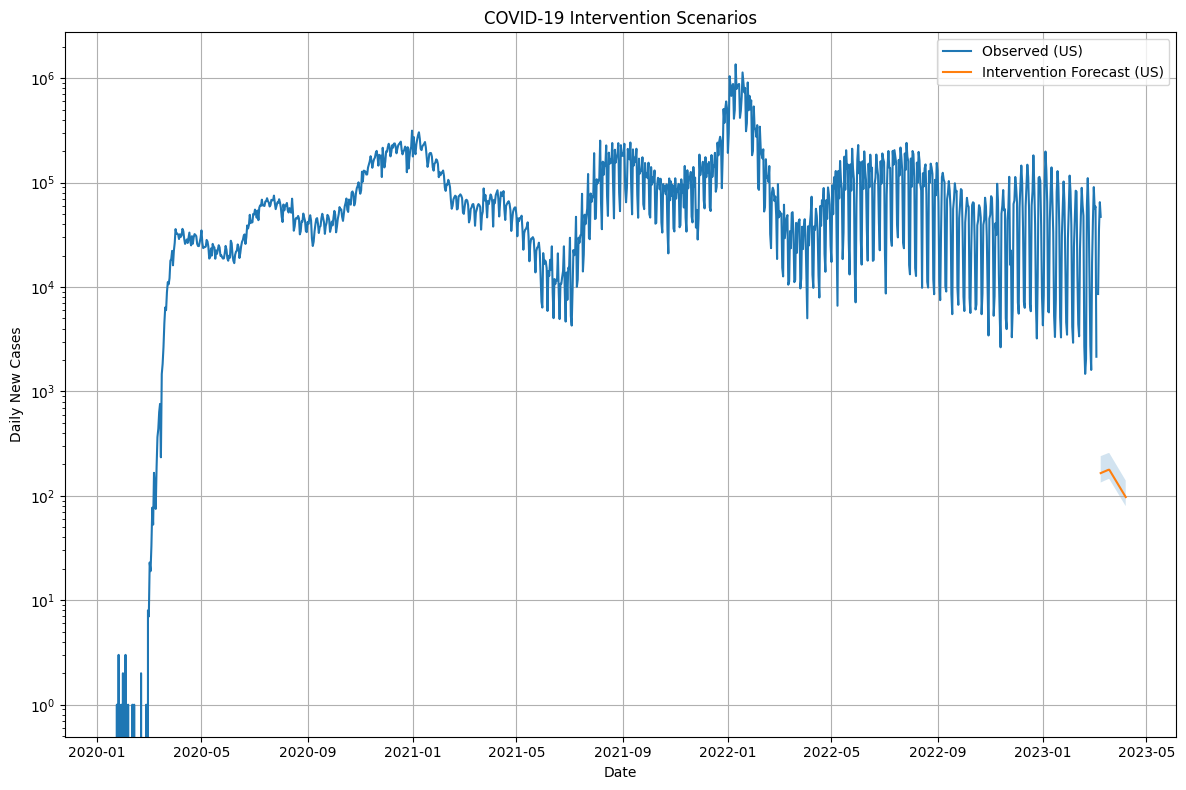

In [41]:
def simulate_intervention(trace, intervention_effect=0.5, intervention_days=10, forecast_days=30):
    """
    Simulate the impact of interventions on SIR model parameters.

    Parameters:
    -----------
    trace : InferenceData
        Posterior samples from PyMC trace.
    intervention_effect : float
        Reduction factor applied to beta to simulate intervention.
    intervention_days : int
        Days after which intervention begins.
    forecast_days : int
        Number of forecast days to simulate.
    """
    t = np.arange(forecast_days)
    N = 1e6  # Approximate population size
    interventions = {}

    for i, country in enumerate(countries):
        beta_samples = trace.posterior['beta'].values[:, :, i].flatten()
        gamma_samples = trace.posterior['gamma'].values.flatten()
        I0_samples = trace.posterior['I0'].values[:, :, i].flatten()

        predictions = []
        for beta, gamma, I0 in zip(beta_samples, gamma_samples, I0_samples):
            S0 = N - I0
            y0 = [S0, I0, 0]
            params_no_interv = [beta, gamma]
            params_interv = [beta * intervention_effect, gamma]

            solution = np.zeros((forecast_days, 3))
            solution[:intervention_days, :] = odeint(sir_ode, y0, np.arange(intervention_days), args=(params_no_interv,))
            solution[intervention_days:, :] = odeint(sir_ode, solution[intervention_days-1], t[intervention_days:], args=(params_interv,))

            predictions.append(solution[:, 1])  # Infected compartment

        # Store results for plotting
        predictions = np.array(predictions)
        interventions[country] = {
            'mean': predictions.mean(axis=0),
            'lower': np.percentile(predictions, 2.5, axis=0),
            'upper': np.percentile(predictions, 97.5, axis=0)
        }

    return interventions

# Generate intervention forecasts
interventions = simulate_intervention(trace, intervention_effect=0.5, intervention_days=10)

# Plot intervention results
def plot_interventions(interventions, df, countries):
    plt.figure(figsize=(12, 8))
    for country in countries:
        historical = np.exp(df[country].values) - 1
        plt.plot(df['index'], historical, label=f'Observed ({country})')

        intervention = interventions[country]
        forecast_dates = pd.date_range(df['index'].iloc[-1], periods=len(intervention['mean']), freq='D')
        plt.plot(forecast_dates, intervention['mean'], label=f'Intervention Forecast ({country})')
        plt.fill_between(forecast_dates, intervention['lower'], intervention['upper'], alpha=0.2)

    plt.yscale('log')
    plt.title('COVID-19 Intervention Scenarios')
    plt.xlabel('Date')
    plt.ylabel('Daily New Cases')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plot_interventions(interventions, df, countries)
plt.show()


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def validate_model(predictions, observed_data, countries):
    """
    Calculate RMSE and MAE to evaluate model.

    Modified to access predictions from InferenceData object correctly.
    """
    rmse = {}
    mae = {}
    for country in countries:  # Iterate through countries
        y_true = np.exp(observed_data[country].values) - 1  # Reverse log-transform
        y_pred = predictions.posterior_predictive['obs'].values[:, countries.index(country), :].flatten()

        # Create a mask to filter out NaN values in y_true and y_pred
        valid_mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        y_true_valid = y_true[valid_mask]
        y_pred_valid = y_pred[valid_mask]

        # Calculate RMSE and MAE for valid data points
        rmse[country] = mean_squared_error(y_true_valid, y_pred_valid, squared=False)
        mae[country] = mean_absolute_error(y_true_valid, y_pred_valid)

    return rmse, mae

# Evaluate model performance
# Pass the `countries` list to validate_model
rmse, mae = validate_model(predictions, df, countries)
print("Validation RMSE:", rmse)
print("Validation MAE:", mae)


Validation RMSE: {'US': 155780.26502005217}
Validation MAE: {'US': 90891.93332144237}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


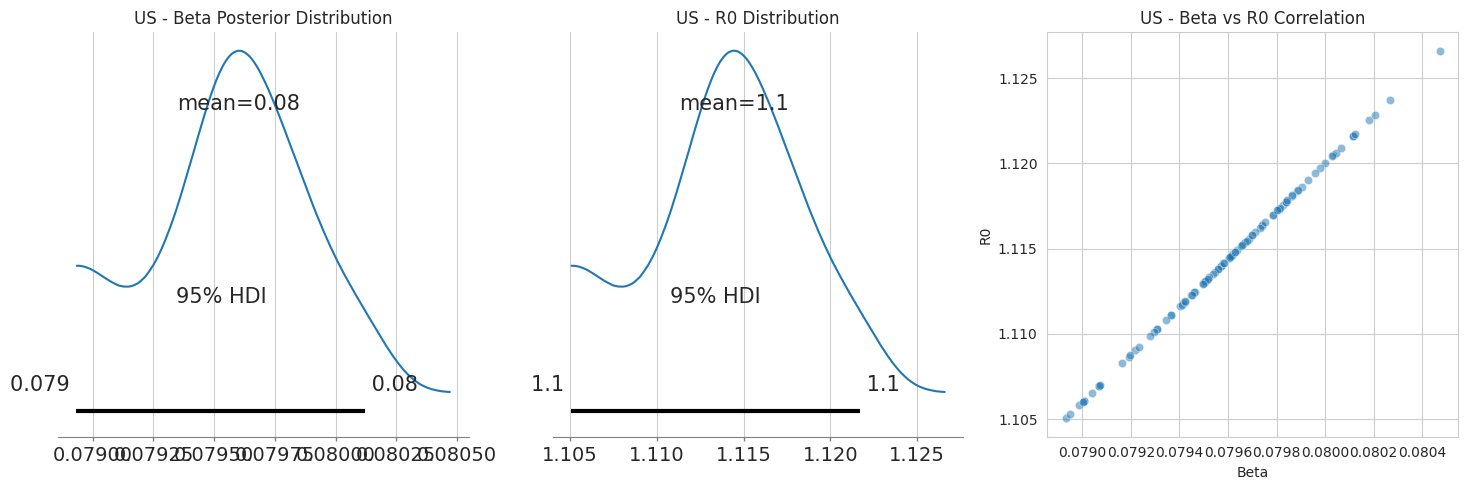


Model Parameter Insights:

US:
Mean transmission rate (β): 0.080
Mean basic reproduction number (R0): 1.114


In [75]:
def interpret_parameters(trace, countries):
    """
    Analyze and visualize model parameters and their relationships.
    """
    n_countries = len(countries)

    # Fix: Create figure and axes correctly for a single country
    if n_countries == 1:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes = axes.reshape(1, -1)  # Reshape to 2D array for consistent indexing
    else:
        fig, axes = plt.subplots(n_countries, 3, figsize=(15, 5 * n_countries))

    for i, country in enumerate(countries):
        # Beta (transmission rate) analysis
        beta_samples = trace.posterior['beta'].values.flatten()
        beta_samples = np.random.choice(beta_samples, size=min(10000, len(beta_samples)), replace=False)
        az.plot_posterior(beta_samples, ax=axes[i, 0], hdi_prob=0.95)
        axes[i, 0].set_title(f"{country} - Beta Posterior Distribution")

        # R0 calculation and visualization
        gamma_samples = trace.posterior['gamma'].values.flatten()
        gamma_samples = np.random.choice(gamma_samples, size=len(beta_samples), replace=False)
        r0_samples = beta_samples / gamma_samples
        az.plot_posterior(r0_samples, ax=axes[i, 1], hdi_prob=0.95)
        axes[i, 1].set_title(f"{country} - R0 Distribution")

        # Parameter correlation
        sns.scatterplot(x=beta_samples, y=r0_samples, ax=axes[i, 2], alpha=0.5)
        axes[i, 2].set_xlabel('Beta')
        axes[i, 2].set_ylabel('R0')
        axes[i, 2].set_title(f"{country} - Beta vs R0 Correlation")

    plt.tight_layout()

    # Calculate statistics
    mean_beta = {country: float(trace.posterior['beta'].mean())  # Convert to float
                 for i, country in enumerate(countries)}
    mean_r0 = {country: float((trace.posterior['beta'] / trace.posterior['gamma']).mean())
               for i, country in enumerate(countries)}

    return {'mean_beta': mean_beta, 'mean_r0': mean_r0}, fig

# Example usage:
parameter_stats, param_fig = interpret_parameters(trace, countries)
plt.show()

# Print the parameter statistics
print("\nModel Parameter Insights:")
for country in countries:
    print(f"\n{country}:")
    print(f"Mean transmission rate (β): {parameter_stats['mean_beta'][country]:.3f}")
    print(f"Mean basic reproduction number (R0): {parameter_stats['mean_r0'][country]:.3f}")


Model Parameter Insights:

US:
Mean transmission rate (β): 0.080
Mean basic reproduction number (R0): 1.114


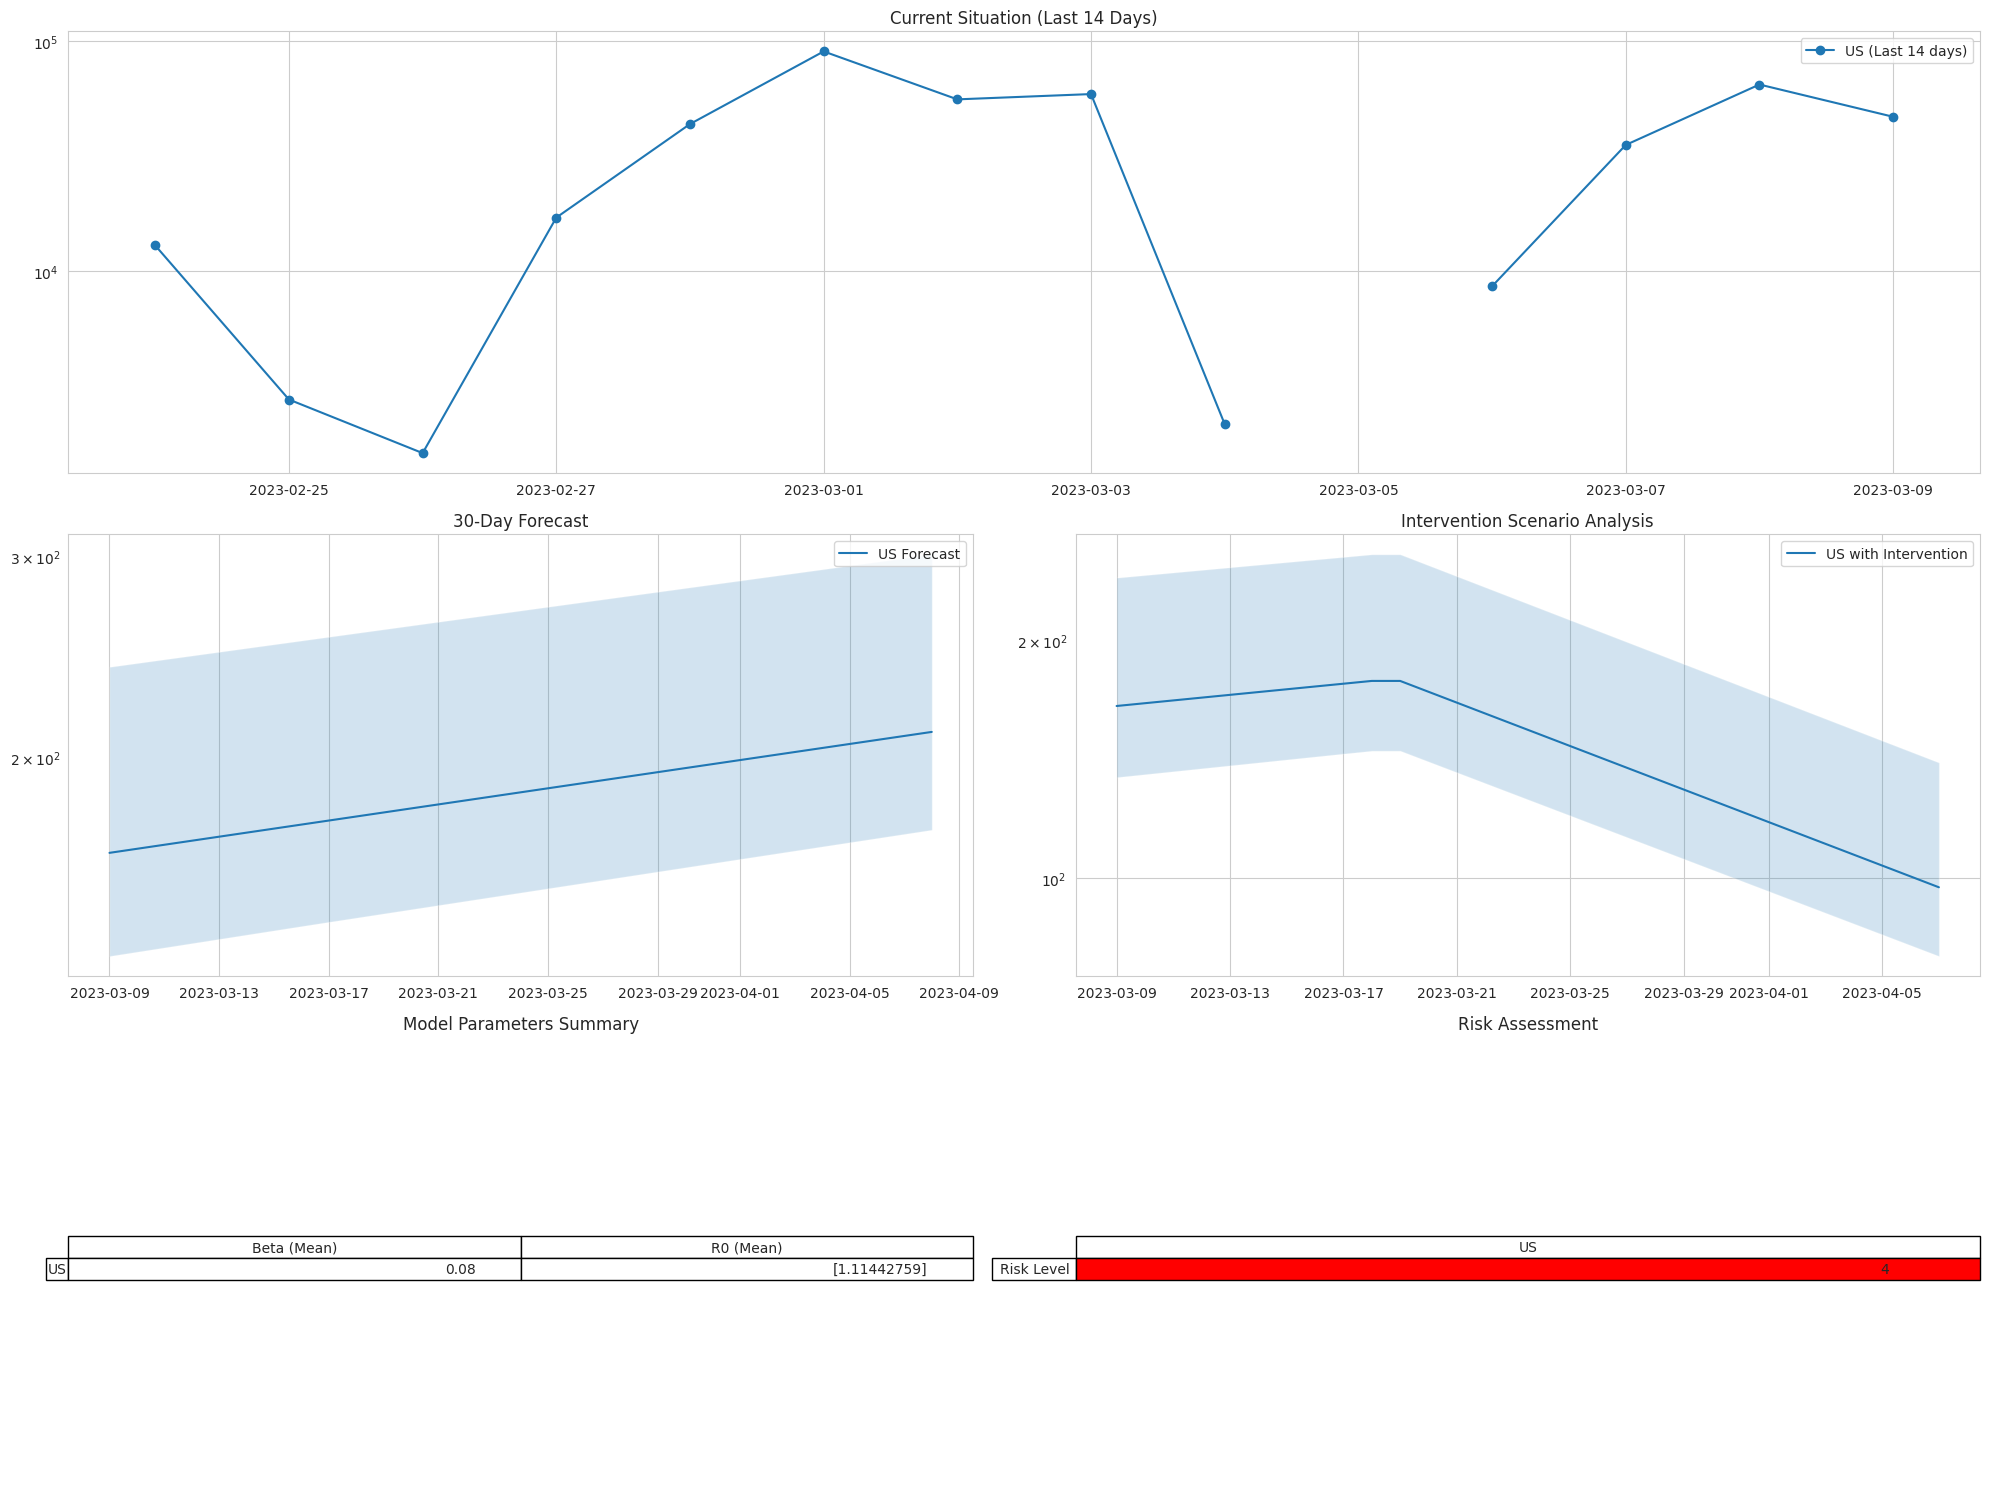

In [76]:
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

def create_monitoring_dashboard(df, forecasts, interventions, trace, countries):
    """
    Create a comprehensive monitoring dashboard for real-time analysis.
    """
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)

    # 1. Current Situation Plot
    ax1 = fig.add_subplot(gs[0, :])
    for country in countries:
        current_cases = np.exp(df[country].values[-14:]) - 1  # Last 14 days
        dates = df['index'][-14:]
        ax1.plot(dates, current_cases, 'o-', label=f'{country} (Last 14 days)')
    ax1.set_title('Current Situation (Last 14 Days)')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True)

    # 2. Forecasting Plot
    ax2 = fig.add_subplot(gs[1, 0])
    for country in countries:
        forecast = forecasts[country]
        ax2.plot(forecast['dates'], forecast['mean'], label=f'{country} Forecast')
        ax2.fill_between(forecast['dates'], forecast['lower'], forecast['upper'], alpha=0.2)
    ax2.set_title('30-Day Forecast')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True)

    # 3. Intervention Analysis
    ax3 = fig.add_subplot(gs[1, 1])
    for country in countries:
        intervention = interventions[country]
        dates = pd.date_range(df['index'].iloc[-1], periods=len(intervention['mean']), freq='D')
        ax3.plot(dates, intervention['mean'], label=f'{country} with Intervention')
        ax3.fill_between(dates, intervention['lower'], intervention['upper'], alpha=0.2)
    ax3.set_title('Intervention Scenario Analysis')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True)

    # 4. Model Parameters Summary
    ax4 = fig.add_subplot(gs[2, 0])
    parameter_summary = pd.DataFrame({
        'Beta (Mean)': [trace.posterior['beta'].mean(['chain', 'draw']).values[i] for i in range(len(countries))],
        'R0 (Mean)': [(trace.posterior['beta'] / trace.posterior['gamma']).mean(['chain', 'draw']).values[i]
                      for i in range(len(countries))]
    }, index=countries)
    ax4.table(cellText=parameter_summary.round(3).values,
              rowLabels=parameter_summary.index,
              colLabels=parameter_summary.columns,
              loc='center')
    ax4.set_title('Model Parameters Summary')
    ax4.axis('off')

    # 5. Uncertainty and Risk Assessment
    ax5 = fig.add_subplot(gs[2, 1])
    risk_levels = calculate_risk_levels(df, forecasts, countries)
    colors = ['green', 'yellow', 'orange', 'red']
    risk_df = pd.DataFrame(risk_levels, index=['Risk Level'])
    ax5.table(cellText=risk_df.values,
              rowLabels=risk_df.index,
              colLabels=countries,
              cellColours=[[colors[level-1] for level in risk_df.iloc[0]]],
              loc='center')
    ax5.set_title('Risk Assessment')
    ax5.axis('off')

    plt.tight_layout()
    return fig

def calculate_risk_levels(df, forecasts, countries):
    """
    Calculate risk levels based on recent trends and forecasts.
    1: Low, 2: Medium, 3: High, 4: Very High
    """
    risk_levels = {}
    for country in countries:
        # Get recent growth rate
        recent_cases = np.exp(df[country].values[-14:]) - 1
        growth_rate = (recent_cases[-1] / recent_cases[0]) - 1

        # Get forecast trend
        forecast_trend = forecasts[country]['mean'][-1] / forecasts[country]['mean'][0]

        # Calculate risk level based on growth rate and forecast trend
        if growth_rate < 0 and forecast_trend < 1:
            risk_levels[country] = 1  # Low
        elif growth_rate < 0.5 and forecast_trend < 1.5:
            risk_levels[country] = 2  # Medium
        elif growth_rate < 1 and forecast_trend < 2:
            risk_levels[country] = 3  # High
        else:
            risk_levels[country] = 4  # Very High

    return risk_levels

def update_real_time_analysis(df, model, trace, countries):
    """
    Update analysis with new data points
    """
    current_date = datetime.now()
    last_data_date = pd.to_datetime(df['index'].max())

    if (current_date - last_data_date).days > 1:
        print(f"Warning: Data last updated {(current_date - last_data_date).days} days ago")

    # Generate new forecasts
    forecasts = forecast_sir_model(trace, df, countries)

    # Generate intervention scenarios
    interventions = simulate_intervention(trace, intervention_effect=0.5, intervention_days=10)

    # Create updated dashboard
    dashboard = create_monitoring_dashboard(df, forecasts, interventions, trace, countries)

    return dashboard, forecasts, interventions


# Create and display the monitoring dashboard
dashboard_fig, new_forecasts, new_interventions = update_real_time_analysis(df, model, trace, countries)
dashboard_fig.show()

# Print parameter insights
print("\nModel Parameter Insights:")
for country in countries:
    print(f"\n{country}:")
    print(f"Mean transmission rate (β): {parameter_stats['mean_beta'][country]:.3f}")
    print(f"Mean basic reproduction number (R0): {parameter_stats['mean_r0'][country]:.3f}")